## MaxEnt IRL on Maze data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from copy import deepcopy
import matplotlib.colors as cl
from matplotlib import rc
rc('text', usetex=True)

import sys
sys.path.insert(0, 'utils/')
    
import maxent_irl as mi

from GR_Maze_Utils import *

# MM's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

TestTrajModule()


'OK'

In [2]:
def get_recurrence_times(nodes_to_count,names,data_to_node):
    collect_recurs = []
    for node in nodes_to_count:
        temp_recurs = []
        for nickname in names:
            nodes,times = get_nodes_from_data(nickname,data_to_node)

            visits_ts = np.array([times[i] for i in range(len(nodes)) if nodes[i] == node])
            recur_ts = visits_ts[1:] - visits_ts[:-1]

            temp_recurs += list(recur_ts)

        collect_recurs += [temp_recurs]
    return np.array(collect_recurs)

In [3]:
#get states (i.e., directed edges)
def get_states_actions_seqs_from_node_seqs(nodes):
    G = create_binary_tree_directed(6)
    states_seq = []
    actions_seq = []
    for ep in nodes:
        temp = []
        temp2 = []
        for i in range(len(ep)-1):
            state = (ep[i],ep[i+1])
            if len(ep[i+1]) > len(ep[i]):
                action = int(ep[i+1][-1])
            else:
                action = 2
            index = get_state_index(state,G)
            temp += [index]
            temp2 += [action]
        states_seq += [temp[:-1]]
        actions_seq += [temp2[1:]]
    return states_seq, actions_seq

def get_state_action_trajectories_from_seqs(states_seq,actions_seq,T):
    trajs_s = []
    trajs_a = []
    for sseq,aseq in zip(states_seq,actions_seq):
        if len(sseq) < T+1:
            continue
        else:
            for i in range(len(sseq)-T):
                trajs_s += [sseq[i:i+T+1]]
                trajs_a += [aseq[i:i+T+1]]
    return np.array(trajs_s,dtype=int),np.array(trajs_a,dtype=int)

In [4]:
# Define and populate the maze structure ma, used as an argument for many functions
ma=NewMaze(6)
sta = TransMatrix(ma)

# Some lists of nicknames for mice
RewNames=['B1','B2','B3','B4','C1','C3','C6','C7','C8','C9']
UnrewNames=['B5','B6','B7','D3','D4','D5','D6','D7','D8','D9']
AllNames=RewNames+UnrewNames
UnrewNamesSub=['B5','B6','B7','D3','D4','D5','D7','D8','D9'] # excluding D6 which barely entered the maze

In [5]:
#Consistency check
#Check if exploration biases match those measured by Rosenberg et al Figure 8 - supplement 1

depth = 6
data_to_node = get_data_index_to_node_dict(depth)
names = RewNames+ UnrewNamesSub
means = np.zeros((len(names),4))
print("MouseID   P_SF  P_SA  P_BF  P_BS")
for i,nickname in enumerate(names):
    nodes,times = get_nodes_from_data(nickname,data_to_node,thresh = 10)
    actions,forced = get_actions_from_nodes(nodes,depth)     
    biases = get_four_biases(actions,forced)
    P_SF = biases[0]
    P_SA = biases[1]
    P_BF = biases[2]
    P_BS = biases[3]
    means[i] = biases
    print(nickname,"       %.2f  %.2f  %.2f  %.2f" %(P_SF,P_SA,P_BF,P_BS))
means_rew = np.mean(means[:10],axis=0)
means_unrew = np.mean(means[10:],axis=0)

print("MeanRew   %.2f  %.2f  %.2f  %.2f" %(means_rew[0],means_rew[1],means_rew[2],means_rew[3]))
print("MeanUnRew %.2f  %.2f  %.2f  %.2f" %(means_unrew[0],means_unrew[1],means_unrew[2],means_unrew[3]))

MouseID   P_SF  P_SA  P_BF  P_BS
B1        0.77  0.76  0.84  0.64
B2        0.78  0.72  0.80  0.63
B3        0.76  0.75  0.83  0.63
B4        0.75  0.72  0.73  0.63
C1        0.82  0.69  0.80  0.65
C3        0.75  0.70  0.82  0.65
C6        0.83  0.76  0.86  0.60
C7        0.78  0.72  0.81  0.66
C8        0.73  0.70  0.76  0.66
C9        0.77  0.74  0.79  0.66
B5        0.77  0.71  0.80  0.58
B6        0.71  0.73  0.76  0.61
B7        0.74  0.70  0.76  0.62
D3        0.78  0.71  0.84  0.60
D4        0.79  0.73  0.81  0.62
D5        0.79  0.69  0.77  0.61
D7        0.78  0.74  0.77  0.65
D8        0.79  0.74  0.74  0.59
D9        0.74  0.69  0.73  0.62
MeanRew   0.77  0.73  0.80  0.64
MeanUnRew 0.77  0.71  0.78  0.61


### Apply MaxEnt IRL on unrewarded mice data

In [18]:
#Pull state-action sequences from unrewarded mice trajectories.
#Each trajectory/episode is a run from home until it gets back home. 

nodes_all = []
names = UnrewNamesSub
print("Cumulative # of episodes")
for nickname in names[:]:
    nodes,times = get_nodes_from_data_episodic(nickname,data_to_node,thresh = 1)
    nodes_all += nodes
    print(len(nodes_all))
states_seq, actions_seq = get_states_actions_seqs_from_node_seqs(nodes_all)

Cumulative # of episodes
203
398
528
681
883
1052
1159
1254
1343


In [19]:
#Apply MaxEnt IRL

gam = 0.8 #discount factor
T = int(2.5/(1-gam)) #horizon
trajs_s,trajs_a = get_state_action_trajectories_from_seqs(states_seq,actions_seq,T) 

Tmat = get_transition_matrix(6)
G = create_binary_tree_directed(6)
index_to_state = get_index_to_state_vec(G)
S = len(index_to_state)
A = 3 

pt_emp = mi.get_empirical_frequencies(trajs_s,trajs_a,S,A)
p0 = mi.get_p0(pt_emp)
print("Negative log-likelihood")
lamb = mi.get_rewards(pt_emp,Tmat,gam)
pt_lamb, log_Z = mi.compute_pt_lamb(lamb,Tmat,p0,gam,T) 
pol_lamb = mi.get_policy(lamb,pt_emp,Tmat,p0,gam) #get inferred policy

Negative log-likelihood
14.279847388739682
14.133246008465203
13.609312916879755
12.511664952847827
12.227259147040659
12.211149079293936
12.15529598830226
12.162390326191709
11.999421694077546
11.817455946184337
11.659058677641701
11.564539988520806
11.34999708513956
11.23419312708376
11.201323527930832
11.174375163000573
11.127721797860062
11.068675993112656
11.010549362764454
10.939811890056303
10.894068626106371
10.86794218883288
10.821905410265668
10.795998188930303
10.774145225572557
10.720742515159756
10.70162559702815
10.694833017182415


In [20]:
#View inferred policy and Q values
np.set_printoptions(precision = 3, suppress=True)
for i in range(S):
    print(i,pol_lamb[i,:], lamb[i,:],index_to_state[i])
    print("")

0 [0.373 0.627 0.   ] [ 2.592  2.957 -5.674] ('r', 'r0')

1 [0.039 0.961 0.   ] [ -0.148   3.121 -10.618] ('r0', 'r')

2 [0.501 0.497 0.002] [ 2.782  2.778 -2.678] ('r', 'r1')

3 [0.945 0.055 0.   ] [  3.131   0.361 -10.183] ('r1', 'r')

4 [0.    0.532 0.468] [-8.288  2.697  2.842] ('r00', 'r0')

5 [0.375 0.625 0.   ] [ 2.43   2.869 -6.074] ('r0', 'r00')

6 [0.    0.417 0.583] [-9.606  2.63   3.033] ('r10', 'r1')

7 [0.406 0.594 0.   ] [ 2.6    2.793 -6.929] ('r1', 'r10')

8 [0.447 0.    0.553] [ 2.712 -9.046  3.045] ('r01', 'r0')

9 [0.692 0.308 0.   ] [ 2.893  2.332 -6.007] ('r0', 'r01')

10 [0.483 0.    0.517] [ 2.808 -7.762  2.949] ('r11', 'r1')

11 [0.665 0.335 0.   ] [ 2.944  2.395 -6.958] ('r1', 'r11')

12 [0.    0.485 0.515] [-7.783  2.775  2.74 ] ('r000', 'r00')

13 [0.182 0.818 0.   ] [ 1.647  2.964 -6.168] ('r00', 'r000')

14 [0.    0.333 0.667] [-7.972  2.353  3.019] ('r100', 'r10')

15 [0.136 0.864 0.   ] [ 1.81   3.073 -4.774] ('r10', 'r100')

16 [0.    0.373 0.627] [-9.7

186 [0.337 0.255 0.408] [2.784 2.778 2.476] ('r111110', 'r11111')

187 [0. 0. 1.] [-6.211 -6.215  2.882] ('r11111', 'r111110')

188 [0.328 0.317 0.355] [2.909 2.775 2.342] ('r000001', 'r00000')

189 [0. 0. 1.] [-6.738 -6.882  2.885] ('r00000', 'r000001')

190 [0.487 0.034 0.479] [3.223 0.298 2.598] ('r100001', 'r10000')

191 [0. 0. 1.] [-5.327 -5.181  3.229] ('r10000', 'r100001')

192 [0.265 0.32  0.415] [2.693 2.8   2.553] ('r010001', 'r01000')

193 [0. 0. 1.] [-7.416 -7.488  2.829] ('r01000', 'r010001')

194 [0.256 0.431 0.313] [2.907 2.937 2.231] ('r110001', 'r11000')

195 [0. 0. 1.] [-6.734 -6.97   3.031] ('r11000', 'r110001')

196 [0.391 0.238 0.37 ] [2.972 2.494 2.443] ('r001001', 'r00100')

197 [0. 0. 1.] [-10.564 -10.567   2.853] ('r00100', 'r001001')

198 [0.544 0.244 0.213] [3.222 2.536 1.862] ('r101001', 'r10100')

199 [0. 0. 1.] [-8.963 -9.05   2.89 ] ('r10100', 'r101001')

200 [0.563 0.099 0.338] [3.201 1.408 2.195] ('r011001', 'r01100')

201 [0. 0. 1.] [-7.639 -7.509  3.0

In [233]:
#np.save("unrew_mice_Qvalues.npy",np.log(pol_lamb + 1e-5))

### Apply MaxEnt IRL on rewarded mice data

In [21]:
#Pull state-action sequences from rewarded mice trajectories.
#Each trajectory/episode is a run from home until it gets back home. 

nodes_all = []
names = RewNames
print("Cumulative # of episodes")
for nickname in names[:]:
    nodes,times = get_nodes_from_data_episodic(nickname,data_to_node,thresh = 1) #to exclude runs from home and to home, set threshold > 6 
    nodes_all += nodes
    print(len(nodes_all))
states_seq, actions_seq = get_states_actions_seqs_from_node_seqs(nodes_all)

Cumulative # of episodes
82
244
344
553
722
1033
1172
1293
1455
1578


In [22]:
#Apply MaxEnt IRL

gam = 0.8 #discount factor
T = int(2.5/(1-gam)) #horizon
trajs_s,trajs_a = get_state_action_trajectories_from_seqs(states_seq,actions_seq,T) 

Tmat = get_transition_matrix(6)
G = create_binary_tree_directed(6)
index_to_state = get_index_to_state_vec(G)
S = len(index_to_state)
A = 3 

pt_emp = mi.get_empirical_frequencies(trajs_s,trajs_a,S,A)
p0 = mi.get_p0(pt_emp)
print("Negative log-likelihood")
lamb = mi.get_rewards(pt_emp,Tmat,gam)
pt_lamb, log_Z = mi.compute_pt_lamb(lamb,Tmat,p0,gam,T) 
pol_lamb = mi.get_policy(lamb,pt_emp,Tmat,p0,gam) #get inferred policy

Negative log-likelihood
14.317622412193545
14.13813489441739
13.548018436982977
12.90799334590005
12.597685248671636
12.354276252374543
12.082767221226387
11.851358978107417
11.65442031352222
11.41676784190295
11.315000481333387
11.22851049874398
11.197697897939953
11.159532270978774
11.05381341895742
10.945356723747889
10.89973774500479
10.86499501006316
10.816967539615426
10.754646285598568
10.72998692839463
10.710605903600104
10.680103366061571
10.62543379875861
10.599951723843487
10.595400469161874


In [24]:
#View inferred policy and Q values
np.set_printoptions(precision = 3, suppress=True)
for i in range(S):
    print(i,pol_lamb[i,:], lamb[i,:],index_to_state[i])
    print("")

0 [0.478 0.522 0.   ] [ 2.436  2.533 -5.827] ('r', 'r0')

1 [0.001 0.999 0.   ] [-4.698  2.946 -9.159] ('r0', 'r')

2 [0.864 0.136 0.   ] [ 2.969  0.997 -7.738] ('r', 'r1')

3 [0.851 0.149 0.   ] [ 2.771  1.472 -9.457] ('r1', 'r')

4 [0.    0.399 0.601] [-8.126  2.153  3.035] ('r00', 'r0')

5 [0.305 0.694 0.   ] [ 1.897  2.563 -5.78 ] ('r0', 'r00')

6 [0.   0.45 0.55] [-8.756  2.531  2.55 ] ('r10', 'r1')

7 [0.768 0.232 0.   ] [ 3.14   1.655 -8.626] ('r1', 'r10')

8 [0.437 0.    0.563] [ 2.295 -7.326  3.029] ('r01', 'r0')

9 [0.757 0.241 0.002] [ 2.52   1.67  -3.293] ('r0', 'r01')

10 [0.432 0.    0.568] [ 2.519 -7.201  2.489] ('r11', 'r1')

11 [0.79 0.21 0.  ] [ 2.558  1.428 -7.304] ('r1', 'r11')

12 [0.    0.444 0.556] [-6.585  2.254  2.582] ('r000', 'r00')

13 [0.2   0.799 0.002] [ 1.49   2.576 -3.658] ('r00', 'r000')

14 [0.   0.28 0.72] [-9.012  2.212  2.819] ('r100', 'r10')

15 [0.013 0.987 0.   ] [-0.197  3.094 -9.025] ('r10', 'r100')

16 [0.    0.343 0.657] [-7.887  2.221  2.73

167 [0. 0. 1.] [-8.643 -8.612  2.687] ('r10101', 'r101010')

168 [0.041 0.329 0.629] [0.194 2.628 2.479] ('r011010', 'r01101')

169 [0.    0.    0.999] [-5.493 -5.245  2.735] ('r01101', 'r011010')

170 [0.32 0.3  0.38] [2.49  2.764 2.164] ('r111010', 'r11101')

171 [0.    0.    0.999] [-5.653 -5.675  2.434] ('r11101', 'r111010')

172 [0.318 0.197 0.484] [2.288 2.138 2.339] ('r000110', 'r00011')

173 [0. 0. 1.] [-7.395 -7.857  2.641] ('r00011', 'r000110')

174 [0.111 0.433 0.456] [0.95  2.615 2.232] ('r100110', 'r10011')

175 [0. 0. 1.] [-5.969 -6.033  2.965] ('r10011', 'r100110')

176 [0.241 0.351 0.408] [1.952 2.813 2.136] ('r010110', 'r01011')

177 [0. 0. 1.] [-5.786 -5.673  2.67 ] ('r01011', 'r010110')

178 [0.392 0.308 0.3  ] [2.526 2.467 1.835] ('r110110', 'r11011')

179 [0. 0. 1.] [-7.183 -6.944  2.646] ('r11011', 'r110110')

180 [0.33  0.311 0.358] [2.468 2.799 2.181] ('r001110', 'r00111')

181 [0. 0. 1.] [-5.892 -5.621  2.578] ('r00111', 'r001110')

182 [0.356 0.294 0.351] [2.4

In [25]:
#np.save("rew_mice_Qvalues.npy",np.log(pol_lamb + 1e-5))

### Estimate reward by comparing Q values of rewarded (incl. and excl. direct paths from home) and unrewarded mice

In [12]:
goal = 'r100101'

G = create_binary_tree_directed(6)
index_to_state = get_index_to_state_vec(G)

log_pol_rew = np.load("rew_mice_Qvalues.npy")
log_pol_rew2 = np.load("rew_nodirect_mice_Qvalues.npy")
log_pol_unrew = np.load("unrew_mice_Qvalues.npy")

r_ests = []
r_ests2 = []
    
for i in range(5):
    i1 = goal[:-i-2]
    i2 = goal[:-i-1]
    if i == 0:
        a = 1
    else:
        a = int(goal[:-i][-1])
    edge_index  = G[i1][i2]['i']
    
    qrew = log_pol_rew[edge_index]
    qrew2 = log_pol_rew2[edge_index]
    qunrew = log_pol_unrew[edge_index]

    qeffrew = np.log(np.exp(qrew[1-a]) + np.exp(qrew[2]))
    qeffrew2 = np.log(np.exp(qrew2[1-a]) + np.exp(qrew2[2]))
    qeffunrew = np.log(np.exp(qunrew[1-a]) + np.exp(qunrew[2]))

    out1 = (qrew[a] - qeffrew) - (qunrew[a] - qeffunrew)
    out2 = (qrew2[a] - qeffrew2) - (qunrew[a] - qeffunrew)
    
    print("%.3f  %.3f" %(out1,out2),i1,i2,a)
    print("Rew (incl. home): ",np.exp(log_pol_rew[edge_index]))
    print("Rew (excl. home): ",np.exp(log_pol_rew2[edge_index]))
    print("UnRewarded      : ",np.exp(log_pol_unrew[edge_index]))
    print("")
    
    r_ests += [out1]
    r_ests2 += [out2]
    
print("reward estimate incl. paths from home: %.2f" %np.mean(r_ests))
print("reward estimate excl. paths from home: %.2f" %np.mean(r_ests2))

0.922  0.504 r1001 r10010 1
Rew (incl. home):  [0.07860114 0.72219587 0.19923299]
Rew (excl. home):  [0.14441653 0.6313065  0.22430697]
UnRewarded      :  [0.17688815 0.50835121 0.31479063]

2.825  1.325 r100 r1001 0
Rew (incl. home):  [9.88961422e-01 1.10301575e-02 3.84204374e-05]
Rew (excl. home):  [9.52280389e-01 4.76957198e-02 5.38907702e-05]
UnRewarded      :  [0.84126272 0.15624393 0.00252335]

2.331  0.996 r10 r100 1
Rew (incl. home):  [1.67995369e-02 9.83206383e-01 2.40805320e-05]
Rew (excl. home):  [6.10261642e-02 9.38991682e-01 1.21539405e-05]
UnRewarded      :  [1.49291262e-01 8.50336054e-01 4.02684900e-04]

1.532  1.502 r1 r10 0
Rew (incl. home):  [7.56432935e-01 2.43572831e-01 2.42339874e-05]
Rew (excl. home):  [7.50808892e-01 2.49207165e-01 1.39427388e-05]
UnRewarded      :  [4.01553590e-01 5.98419208e-01 5.72018265e-05]

1.864  1.724 r r1 0
Rew (incl. home):  [8.61669514e-01 1.38313902e-01 4.65843150e-05]
Rew (excl. home):  [8.44175203e-01 1.55834444e-01 2.03534337e-05]


In [34]:
def compute_q_r(i,a,log_pol_rew,log_pol_rew2,log_pol_unrew, verbose = False):
    qrew = log_pol_rew[i]
    qrew2 = log_pol_rew2[i]
    qunrew = log_pol_unrew[i]
    
    qeffrew = np.log(np.sum(np.exp(qrew)) - np.exp(qrew[a]))
    qeffrew2 = np.log(np.sum(np.exp(qrew2)) - np.exp(qrew2[a]))
    qeffunrew = np.log(np.sum(np.exp(qunrew)) - np.exp(qunrew[a]))

    out1 = (qrew[a] - qeffrew) - (qunrew[a] - qeffunrew)
    out2 = (qrew2[a] - qeffrew2) - (qunrew[a] - qeffunrew)
    
    if verbose:
        print("Rew (incl. home): ",np.exp(log_pol_rew[i]))
        print("Rew (excl. home): ",np.exp(log_pol_rew2[i]))
        print("UnRewarded      : ",np.exp(log_pol_unrew[i]))
        print("")
    
    return out1,out2

def get_qe(i,a,log_pol_unrew):
    qunrew = log_pol_unrew[i]
    qeffunrew = np.log(np.sum(np.exp(qunrew)) - np.exp(qunrew[a]))
    return qunrew[a] - qeffunrew

#filter nodes based on whether they go towards target or not. 
S = len(index_to_state)
goal = 'r100101'
indices = []
actions = []
qrs = []
qrs2 = []
qes = []
for i in range(S):
    state = index_to_state[i]
    dist1 = find_distance_bn_nodes(goal,state[0]) 
    dist2 = find_distance_bn_nodes(goal,state[1]) 
    if dist2 < dist1 and dist2>0 and dist2 < 12 and len(state[0]) < 7:
        indices += [i]
        if len(state[1]) == 7:
            actions += [2]
        else :
            d0 = find_distance_bn_nodes(goal,state[1] + '0') 
            d1 = find_distance_bn_nodes(goal,state[1] + '1')
            if len(state[1]) == 1:
                d2 = S+1
            else:
                d2 = find_distance_bn_nodes(goal,state[1][:-1])
            actions += [np.argmin([d0,d1,d2])]
        qr,qr2 = compute_q_r(i,actions[-1],log_pol_rew,log_pol_rew2,log_pol_unrew, verbose = False)
        qrs += [qr]
        qrs2 += [qr2]
        #print(state[0],state[1],actions[-1])
print(len(indices))

62


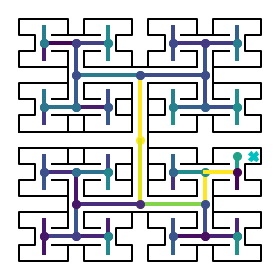

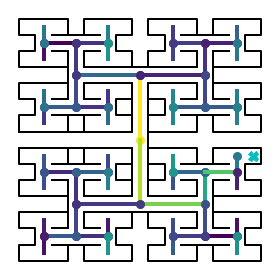

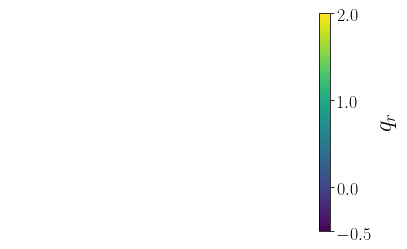

In [35]:
def convert_node_to_maze_pos(node):
    pos = convert_node_to_pos(node)
    return np.array([pos[0]*8 + 7, -pos[1]*8 + 7])

norm = cl.Normalize(vmin=-0.5, vmax=2, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

def get_colors(indices,qs,mapper):
    arrows = np.zeros((len(indices),2,2))
    markers = []
    colors = []
    for i in range(len(indices)):
        state = index_to_state[indices[i]]
        arrows[i,:,0] = convert_node_to_maze_pos(state[0])
        arrows[i,:,1] = convert_node_to_maze_pos(state[1])
        if arrows[i,0,1] > arrows[i,0,0] and np.abs(arrows[i,1,1]- arrows[i,1,0]) < 0.25:
            markers += ['>']
        elif arrows[i,0,1] < arrows[i,0,0]  and np.abs(arrows[i,1,1]- arrows[i,1,0]) < 0.25:
            markers += ['<']
        elif arrows[i,1,1]  > arrows[i,1,0] and np.abs(arrows[i,0,1]- arrows[i,0,0]) < 0.25:
            markers += ['v']
        elif arrows[i,1,1] < arrows[i,1,0]  and np.abs(arrows[i,0,1]- arrows[i,0,0]) < 0.25:
            markers += ['^']

        colors += [mapper.to_rgba(qs[i])]
        
    return arrows,colors

goal_pos = convert_node_to_maze_pos('r100101')

arrows,colors = get_colors(indices,qrs,mapper)
arrows,colors2 = get_colors(indices,qrs2,mapper)
    
        
plt.close("all")
PlotMazeFunction(None,ma,mode='nodes',numcol=None,figsize=4,col=None)
for i in range(len(indices)):
    plt.plot(arrows[i,0,:],arrows[i,1,:],'-',lw=4,alpha = 1, color = colors[i])
    plt.plot(arrows[i,0,1],arrows[i,1,1],marker='o',ms=8,alpha = 1, color = colors[i])
plt.plot([goal_pos[0]],[goal_pos[1]],'cX',ms=10)
plt.axis("off")
plt.savefig("./plots/qr_maze.pdf")
plt.show()

plt.close("all")
PlotMazeFunction(None,ma,mode='nodes',numcol=None,figsize=4,col=None)
for i in range(len(indices)):
    plt.plot(arrows[i,0,:],arrows[i,1,:],'-',lw=4,alpha = 1, color = colors2[i])
    plt.plot(arrows[i,0,1],arrows[i,1,1],marker='o',ms=8,alpha = 1, color = colors2[i])
plt.plot([goal_pos[0]],[goal_pos[1]],'cX',ms=10)
plt.axis("off")
plt.savefig("./plots/qr_nodirect_maze.pdf")
plt.show()


plt.close("all")
img = plt.imshow(np.array([[0,1]]), cmap=cm.viridis, vmin = -0.5,vmax = 2)
img.set_visible(False)
plt.axis("off")

cbar= plt.colorbar(orientation="vertical")
cbar.set_ticks([-0.5,0,1,2])
cbar.ax.tick_params(labelsize = 18)
cbar.set_label(r"$q_r$", fontsize = 24)
plt.savefig("./plots/qr_colorbar.pdf")
plt.show()

## Exploration biases

125


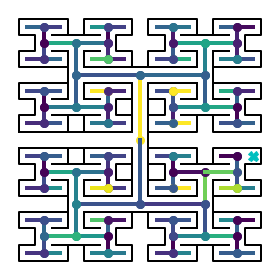

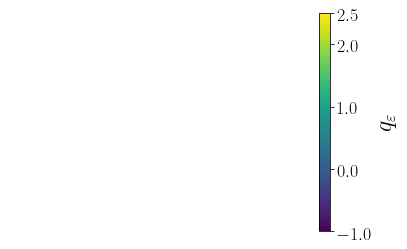

In [41]:
#filter nodes based on whether they go towards target or not. 
vmin = -1
vmax= 2.5
norm = cl.Normalize(vmin= vmin, vmax= vmax, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

S = len(index_to_state)
goal = 'r100101'
indices = []
actions = []
qes = []
for i in range(S):
    state = index_to_state[i]
    dist1 = find_distance_bn_nodes(goal,state[0]) 
    dist2 = find_distance_bn_nodes(goal,state[1]) 
    if dist2 < dist1 and dist2>0 and dist2 < 12 and len(state[0]) < 12:
        indices += [i]
        if len(state[1]) == 7:
            actions += [2]
        else :
            d0 = find_distance_bn_nodes(goal,state[1] + '0') 
            d1 = find_distance_bn_nodes(goal,state[1] + '1')
            if len(state[1]) == 1:
                d2 = S+1
            else:
                d2 = find_distance_bn_nodes(goal,state[1][:-1])
            actions += [np.argmin([d0,d1,d2])]
        qe = get_qe(i,actions[-1],log_pol_unrew)
        qes += [qe]
        #print(state[0],state[1],actions[-1])
print(len(indices))

goal_pos = convert_node_to_maze_pos('r100101')
arrows,colors = get_colors(indices,qes,mapper)

        
plt.close("all")
PlotMazeFunction(None,ma,mode='nodes',numcol=None,figsize=4,col=None)
for i in range(len(indices)):
    plt.plot(arrows[i,0,:],arrows[i,1,:],'-',lw=4,alpha = 1, color = colors[i])
    plt.plot(arrows[i,0,1],arrows[i,1,1],marker='o',ms=8,alpha = 1, color = colors[i])
plt.plot([goal_pos[0]],[goal_pos[1]],'cX',ms=10)
plt.axis("off")
plt.savefig("./plots/qe_maze.pdf")
plt.show()

plt.close("all")
img = plt.imshow(np.array([[0,1]]), cmap=cm.viridis, vmin = vmin,vmax = vmax)
img.set_visible(False)
plt.axis("off")

cbar= plt.colorbar(orientation="vertical")
cbar.set_ticks([-1,0,1,2,2.5])
cbar.ax.tick_params(labelsize = 18)
cbar.set_label(r"$q_{\varepsilon}$", fontsize = 24)
plt.savefig("./plots/qe_colorbar.pdf")
plt.show()

In [6]:
#Check variation in exploration biases over time spent in maze

#Check if exploration biases match those measured by Rosenberg et al Figure 8 - supplement 1

depth = 6
data_to_node = get_data_index_to_node_dict(depth)
names = UnrewNamesSub
means = np.zeros((len(names),4))
print("MouseID   P_SF  P_SA  P_BF  P_BS")

nslices = 4
P_SFs = np.zeros((len(names),nslices))
P_SAs = np.zeros((len(names),nslices))
P_BFs = np.zeros((len(names),nslices))
P_BSs = np.zeros((len(names),nslices))

for i,nickname in enumerate(names):
    nodes,times = get_nodes_from_data(nickname,data_to_node,thresh = 10)
    actions,forced = get_actions_from_nodes(nodes,depth)    
    nps = int(len(actions)/nslices)
    for j in range(nslices):
        if j < nslices - 1:
            biases = get_four_biases(actions[j*nps:(j+1)*nps],forced[j*nps:(j+1)*nps])
        else:
            biases = get_four_biases(actions[j*nps:],forced[j*nps:])
        P_SFs[i,j] = biases[0]
        P_SAs[i,j] = biases[1]
        P_BFs[i,j] = biases[2]
        P_BSs[i,j] = biases[3]
        
    P_SF = np.mean(P_SFs[i])
    P_SA = np.mean(P_SAs[i])
    P_BF = np.mean(P_BFs[i])
    P_BS = np.mean(P_BSs[i])
    
    means[i] = np.array([P_SF,P_SA,P_BF,P_BS])
    print(nickname,"       %.2f  %.2f  %.2f  %.2f" %(P_SF,P_SA,P_BF,P_BS))
means_unrew = np.mean(means[:10],axis=0)
#means_unrew = np.mean(means[10:],axis=0)

print("MeanUnRew   %.2f  %.2f  %.2f  %.2f" %(means_rew[0],means_rew[1],means_rew[2],means_rew[3]))
#print("MeanUnRew %.2f  %.2f  %.2f  %.2f" %(means_unrew[0],means_unrew[1],means_unrew[2],means_unrew[3]))

MouseID   P_SF  P_SA  P_BF  P_BS
B5        0.77  0.71  0.80  0.58
B6        0.72  0.73  0.76  0.61
B7        0.74  0.70  0.76  0.63
D3        0.79  0.71  0.84  0.60
D4        0.79  0.73  0.81  0.62
D5        0.79  0.69  0.77  0.61
D7        0.79  0.74  0.77  0.66
D8        0.79  0.74  0.74  0.59
D9        0.74  0.69  0.73  0.62
MeanUnRew   0.77  0.73  0.80  0.64


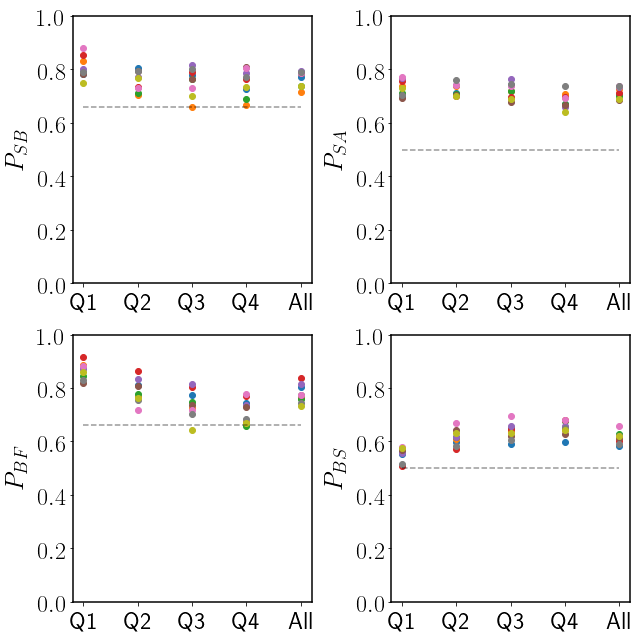

In [35]:
plt.close("all")
fig,axis = plt.subplots(2,2,figsize = (9,9))

baseline = 0.66
for i in range(len(names)):
    for j in range(nslices):
        axis[0][0].plot(j, P_SFs[i,j],'C%do'%i)
        
    axis[0][0].plot([nslices],np.mean(P_SFs[i]),'C%do'%i)
axis[0][0].plot([0,nslices],[baseline,baseline],'k--', alpha = 0.4)
axis[0][0].set_ylabel(r"$P_{SB}$", fontsize = 26)
    
    
baseline = 0.5
for i in range(len(names)):
    for j in range(nslices):
        axis[0][1].plot(j, P_SAs[i,j],'C%do'%i)
        
    axis[0][1].plot([nslices],np.mean(P_SAs[i]),'C%do'%i)
axis[0][1].plot([0,nslices],[baseline,baseline],'k--', alpha = 0.4)
axis[0][1].set_ylabel(r"$P_{SA}$", fontsize = 26)
    
baseline = 0.66
for i in range(len(names)):
    for j in range(nslices):
        axis[1][0].plot(j, P_BFs[i,j],'C%do'%i)
        
    axis[1][0].plot([nslices],np.mean(P_BFs[i]),'C%do'%i)
axis[1][0].plot([0,nslices],[baseline,baseline],'k--', alpha = 0.4)
axis[1][0].set_ylabel(r"$P_{BF}$", fontsize = 26)
    
fig.tight_layout()

baseline = 0.5
for i in range(len(names)):
    for j in range(nslices):
        axis[1][1].plot(j, P_BSs[i,j],'C%do'%i)
        
    axis[1][1].plot([nslices],np.mean(P_BSs[i]),'C%do'%i)
axis[1][1].plot([0,nslices],[baseline,baseline],'k--', alpha = 0.4)
axis[1][1].set_ylabel(r"$P_{BS}$", fontsize = 26)

for ia in range(2):
    for ib in range(2):
        axis[ia][ib].set_ylim(0,1)
        axis[ia][ib].set_xticks(np.arange(nslices+1))
        axis[ia][ib].set_xticklabels(['Q1','Q2','Q3','Q4','All'])
        axis[ia][ib].tick_params(labelsize = 24)
        for sp in ['top','bottom','left','right']:
            axis[ia][ib].spines[sp].set_linewidth(1.5)
    
fig.tight_layout()
plt.savefig("./plots/explo_changes.pdf")
